## Building the graph

### Clipping: All except colabs mentioning "javascript" & "python"

After getting and parsing the data, we need to understand and create metrics that could lead us to our hypothesis and it's impacts.

In [42]:
from netpixi.integration.gt import Graph
import pandas as pd
import numpy as np

g = Graph(directed=False)

In [43]:
data = pd.read_csv("../data/colaboration_comments.csv")

In [44]:
# Add the source repositories (usually belonging to organizations where users collaborate)
data['source'] = list(map(lambda x : x.split("https://github.com/")[-1].split('/')[0],data['URL']))

In [45]:
#All except colabs mentioning "javascript" & "python"
data = data[data['BODY'].notna() & ~data['BODY'].str.lower().apply(lambda x: 'javascript' in str(x).lower())]
data = data[data['BODY'].notna() & ~data['BODY'].str.lower().apply(lambda x: 'python' in str(x).lower())]

In [46]:
# Drop columns which we won't use
data = data.drop(['COMMIT_ID','COMMENT_ID','URL'],axis=1)

In [47]:
#First view of data
data

,AUTHOR,CREATED_AT,BODY,source
0,zindlerb,2015-01-01T00:00:08Z,:sparkles: :pray: :sparkles:,selfhub
1,msabramo,2015-01-01T00:00:53Z,> Can you remove this empty line?\r\n\r\nDone.,tsuru
2,myclamm,2015-01-01T00:00:55Z,Thanks man. That's from week 4 of Hack Reactor...,GoldenLions
3,zindlerb,2015-01-01T00:01:44Z,"_.reduce would be more elegant, but your call",selfhub
4,rwjblue,2015-01-01T00:01:54Z,Tiny nit-pick: can you name this something mea...,emberjs
...,...,...,...,...
635297,rings360,2015-02-28T09:59:16Z,Asar Sunny <ring2rings93@gmail.com>,AGV-IIT-KGP
635298,jeffcarp,2015-02-28T09:59:16Z,Thank you for doing this! Would you mind if I ...,veswill3
635299,msabramo,2015-02-28T09:59:42Z,Done.,Robpol86
635300,msabramo,2015-02-28T09:59:52Z,Done.,Robpol86


In [48]:
#Looking to the total contribuitions for the users in the source repositories
total_contributions = data.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
total_contributions

AUTHOR
houndci       25564
nrel-bot       2997
bors-servo     2123
jirikuncar     2079
miabot         1784
              ...  
goodtaster        1
googlesky         1
googley           1
googyanas         1
iredpath          1
Name: source, Length: 63293, dtype: int64

In [49]:
# As we can see there are many contribuitors who participated much less than the average, we're going to use this to filter 
# the data: contribuitors who has less contributions than the average will not be considered for the network
total_contributions.describe()

count    63293.000000
mean         9.886638
std        108.203376
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      25564.000000
Name: source, dtype: float64

In [50]:
#Cleaning the data as explaneid above
contribuitors = data.groupby(['source']).count()['AUTHOR'].sort_values(ascending=False)
contribuitors_mean = contribuitors.mean()
repos_edge = contribuitors[contribuitors>contribuitors_mean]
repos_edge.index

Index(['mozilla', 'aspnet', 'edx', 'apache', 'rust-lang', 'caskdata',
       'GoogleCloudPlatform', 'mozilla-b2g', 'Homebrew', 'NREL',
       ...
       'pkulchenko', 'Runalyze', 'SumAll', 'Yasumoto', 'Shougo',
       'michelleeeee', 'motog2014devteam', 'restfb', 'itsapi', 'dennisdoomen'],
      dtype='object', name='source', length=5157)

In [51]:
#filtering
data_clean = data[data['source'].isin(repos_edge.index)]

In [52]:
data_clean

,AUTHOR,CREATED_AT,BODY,source
0,zindlerb,2015-01-01T00:00:08Z,:sparkles: :pray: :sparkles:,selfhub
1,msabramo,2015-01-01T00:00:53Z,> Can you remove this empty line?\r\n\r\nDone.,tsuru
3,zindlerb,2015-01-01T00:01:44Z,"_.reduce would be more elegant, but your call",selfhub
4,rwjblue,2015-01-01T00:01:54Z,Tiny nit-pick: can you name this something mea...,emberjs
5,bradenmacdonald,2015-01-01T00:02:33Z,"Yeah, I will just remove that. It is always True.",edx
...,...,...,...,...
635296,XhmikosR,2015-02-28T09:58:15Z,@kasper93: are you sure [this](https://github....,kasper93
635297,rings360,2015-02-28T09:59:16Z,Asar Sunny <ring2rings93@gmail.com>,AGV-IIT-KGP
635299,msabramo,2015-02-28T09:59:42Z,Done.,Robpol86
635300,msabramo,2015-02-28T09:59:52Z,Done.,Robpol86


We already have the filter to build the network with a good context to define an edge between two collaborators: 

**There are an edge between them if they have at least one collaboration in a relevant source**

Even so, there many developers who collaborate very little, and we need to adjust our data to maintain only developers with a appropriate average frequency in mass of data to avoid any bias due collators with less interactions than the average of collaborations.

In [53]:
#Contributions to define an edge
edge_contrib = data_clean.groupby(['AUTHOR']).count()['source'].sort_values(ascending=False)
#Average contributions
average_contrib =edge_contrib.mean()

## Defining focus

We now need to define a custom metric to help to define our hypothesis: 

**As much a developers belong to a community (obtained by cluster coefficient metric), he has focus in the collaborations**

That way we need to define the concept of focus. Focus will be understanding in this context by: 

*Number of developer collaborations considered for edge formation divided per total collaborations in the data, thoughtful by the Number of developer collaborations per the max Number of collaborations of an individual:*

 $$focus = \frac{edgeContributions_i}{totalContributions_i}\cdot\frac{edgeContributions_i}{maxEdgeContribution}$$
 
 This metric is interesting because as define the percentage of relevant contributions to the graph, it takes into account the quantity of the individual contributions of the developer, giving different weights to them, even the  percentage of relevant contributions is similar, deepening the relevance of this metric.

In [54]:
focus = (edge_contrib/total_contributions)*(edge_contrib/np.max(edge_contrib))
focus = focus.dropna().sort_values(ascending=True)
focus

AUTHOR
bmuschko       0.000002
koriym         0.000002
demobox        0.000002
pexcn          0.000002
davidvossel    0.000002
                 ...   
miabot         0.072168
jirikuncar     0.083698
bors-servo     0.085882
nrel-bot       0.119143
houndci        0.966985
Name: source, Length: 28187, dtype: float64

## Building the Network properly

To the define the network we need to enumerate the collaborators who interact in the same repo by repo, and after it set pairs of developers to create an edge in the network. 

Concurrently we are defining the focus of each developer.

In [55]:
same_repo_colab = data_clean.groupby('source')['AUTHOR'].apply(lambda x: list(np.unique(x)))
same_repo_colab

source
01org          [alexshalamov, chivakker, dawagner, jku, jlaak...
0xAX            [0xAX, Huddayn, akash0x53, ccope, georgehorrell]
10gen                                      [behackett, lovett89]
12factor                            [fernandes, gwmoura, lfilho]
13DeAnda                                      [AndrewDapkiewicz]
                                     ...                        
zotero         [adam3smith, apcshields, aurimasv, bwiernik, d...
zpp-2014-15                                   [trzysiek, xavrin]
zurb           [AntJanus, abdullahsalem, calmass, danielsamue...
zxqfox                              [andrewblond, eGavr, zxqfox]
zyndiecate                                          [zyndiecate]
Name: AUTHOR, Length: 5157, dtype: object

In [56]:
import itertools
import warnings
warnings.filterwarnings('ignore') 

g.add_vp('focus')
g.add_vp('colabs')
for index, row in same_repo_colab.iteritems():
    pairs = itertools.combinations(row, 2)
    for i,pair in enumerate(pairs):
        try:
            g.add_vertex(pair[0])
            u = g.get_vertex(pair[0])
            u['focus'] = focus[pair[0]]
            u['colabs'] = int(edge_contrib[pair[0]])
        except Exception as inst:
            pass
        try:
            g.add_vertex(pair[1])
            v = g.get_vertex(pair[1])
            v['focus'] = focus[pair[1]]
            v['colabs'] = int(edge_contrib[pair[1]])
        except Exception as inst:
            pass
        finally:
            try:
                g.add_edge(pair[0],pair[1])
            except:
                pass

#### Number of vertex in the graph

In [57]:
n = g.num_vertices()
print("g's number of vertex:", n)

g's number of vertex: 28031


#### Number of edges in the graph

In [58]:
m = g.num_edges()
print("g's number of edges:", m)

g's number of edges: 619418


#### Density of the graph

In [59]:
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges

392854465

In [60]:
d = m / max_edges
d
print(f'Density is {d}')

Density is 0.0015767111110726463


### Analyzing the graph

After obtained the general data of the graph, we need to create insights by regression details which describes better if our hypothesis will be confirmed or not.

In [61]:
import seaborn as sns
from netpixi.integration.gt import *
from regression.integration.gt import *

In [62]:
data = gt_data(g)
data.head(5)

,focus,colabs
id,,
alexshalamov,0.000081,2
chivakker,0.000081,2
dawagner,0.000771,20
jku,0.000259,8
jlaako,0.000566,14


##### Adding clustering and degree metrics

In [63]:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)
dc = gt_total_degree(g)
g.add_vp('degree', dc)
data = gt_data(g)
data.describe()

,focus,colabs,clustering,degree
count,28031.000000,28031.000000,28031.000000,28031.000000
mean,0.000705,18.208483,0.908709,0.001577
std,0.006132,156.442669,0.239777,0.002691
min,0.000002,1.000000,0.000000,0.000036
25%,0.000040,1.000000,1.000000,0.000178
50%,0.000162,4.000000,1.000000,0.000428
75%,0.000526,14.000000,1.000000,0.001570
max,0.966985,24720.000000,1.000000,0.043204


In [64]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
data['degree_count'] = degrees
data['degree_count'].describe().to_frame()

,degree_count
count,28031.000000
mean,44.195212
std,75.434305
min,1.000000
25%,5.000000
50%,12.000000
75%,44.000000
max,1211.000000


<AxesSubplot: xlabel='degree_count', ylabel='Count'>

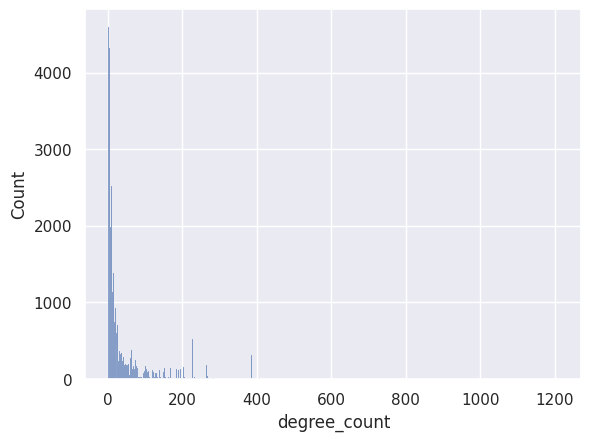

In [65]:
sns.histplot(data['degree_count'])

#### Dropping the outliers (colabs > 1000)

As we can see above there collaborators who are much higher than the collaborations, and much of them are bot's accounts (e.g *houndci* and *nrel-bot*). For this, we're removing them for the analysis.

In [66]:
selRows = data[data['colabs'] > 400].index
data = data.drop(selRows,axis=0)

### Normalizing focus

After removing the outliers we need to normalize the focus metric to properly give insights about the data.

In [67]:
x = data['focus']
x_norm = (x-np.min(x))/(np.max(x)-np.min(x)) + 1e-10 #For log issues in the next cells
data['focus'] = x_norm

In [68]:
data['degree'].describe().to_frame()

,degree
count,27966.000000
mean,0.001567
std,0.002659
min,0.000036
25%,0.000178
50%,0.000428
75%,0.001570
max,0.026293


In [69]:
data['focus'].describe().to_frame()

,focus
count,2.796600e+04
mean,3.801854e-02
std,8.347069e-02
min,1.000000e-10
25%,2.429150e-03
50%,1.006362e-02
75%,3.296703e-02
max,1.000000e+00


### Regression 

<AxesSubplot: xlabel='focus', ylabel='Count'>

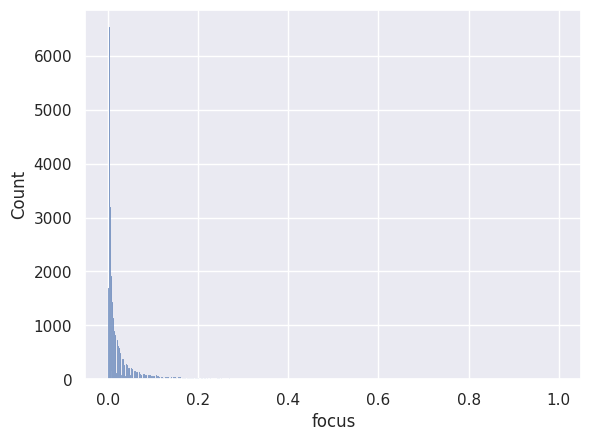

In [70]:
sns.histplot(data['focus'])

<AxesSubplot: xlabel='degree', ylabel='Count'>

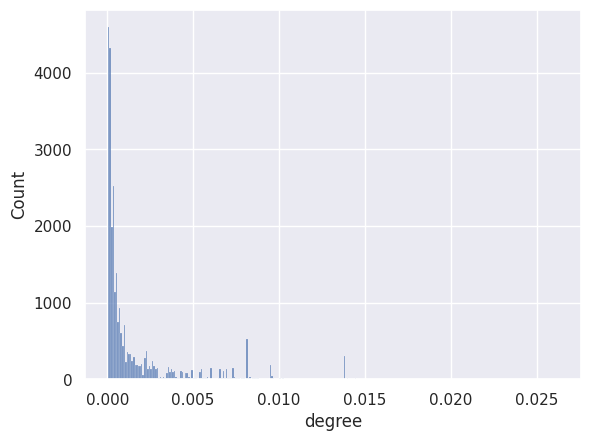

In [71]:
sns.histplot(data['degree'])

In [72]:
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

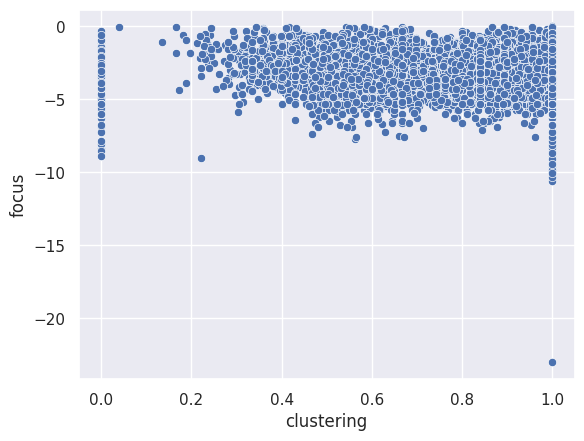

In [73]:
sns.scatterplot(x=data['clustering'], y=np.log(data['focus']));

In [74]:
data.sort_values(by="focus",ascending=False)

,focus,colabs,clustering,degree,degree_count
id,,,,,
yishaigalatzer,1.000000e+00,393,1.000000,0.002640,74
tde-banana-odoo,9.872759e-01,388,0.893801,0.003782,106
jzaefferer,9.847311e-01,387,0.542271,0.003068,86
DanielRosenwasser,9.720333e-01,384,1.000000,0.002283,64
Neamar,9.720069e-01,382,0.666667,0.000214,6
...,...,...,...,...,...
davidvossel,3.402181e-05,1,1.000000,0.000321,9
pexcn,3.402181e-05,1,1.000000,0.004959,139
koriym,2.570539e-05,1,1.000000,0.000250,7


### Residuals

In [75]:
result = reg.linear(data=data, formula='focus ~ clustering')

In [76]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  focus   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     641.5
Date:                Thu, 08 Jun 2023   Prob (F-statistic):          6.07e-140
Time:                        18:28:34   Log-Likelihood:                 30082.
No. Observations:               27966   AIC:                        -6.016e+04
Df Residuals:                   27964   BIC:                        -6.014e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0854      0.002     44.125      0.000       0.082       0.089
clustering    -0.0522      0.002    -25.327      0.000      -0.056      -0.048
==============================================================================
Omnibus:                    28026.633   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1455908.935
Skew:                           5.050   Prob(JB):                         0.00
Kurtosis:                      36.874   Cond. No.                         7.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-0.052169,0.002060,0.000000


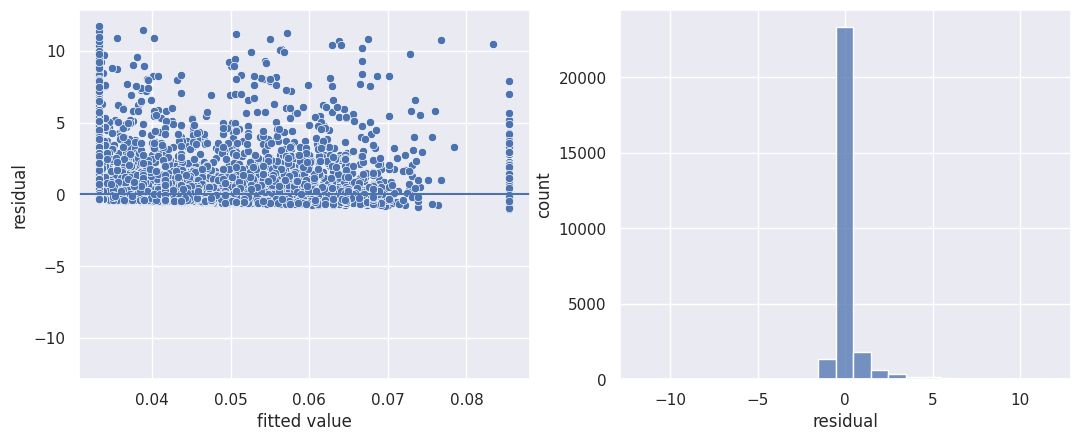

In [78]:
result.plot_residuals()

#### "Massaging" the data

As we can see, the distribution of residuals is not good as we want, because the residuals has not a randomic and normal distribution to give the give the necessary confidence to the model. 

Because of this, we can apply a logaritmic scale to the focus to get a better shape and use the degree as control variable (which means the quantity of neighbors of the vertex).

In [79]:
result = reg.linear(data=data, formula='np.log(focus) ~ clustering + degree')

In [80]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(focus)   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     1105.
Date:                Thu, 08 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:28:37   Log-Likelihood:                -50847.
No. Observations:               27966   AIC:                         1.017e+05
Df Residuals:                   27963   BIC:                         1.017e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0258      0.035    -85.912      0.000      -3.095      -2.957
clustering    -1.6928      0.037    -45.472      0.000      -1.766      -1.620
degree        45.1435      3.354     13.460      0.000      38.570      51.718
==============================================================================
Omnibus:                      498.295   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.372
Skew:                           0.217   Prob(JB):                    3.03e-153
Kurtosis:                       3.643   Cond. No.                         512.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
result.micro_summary()

variable,coefficient,std error,p-value
clustering,-1.692785,0.037227,0.000000
degree,45.143507,3.354001,0.000000


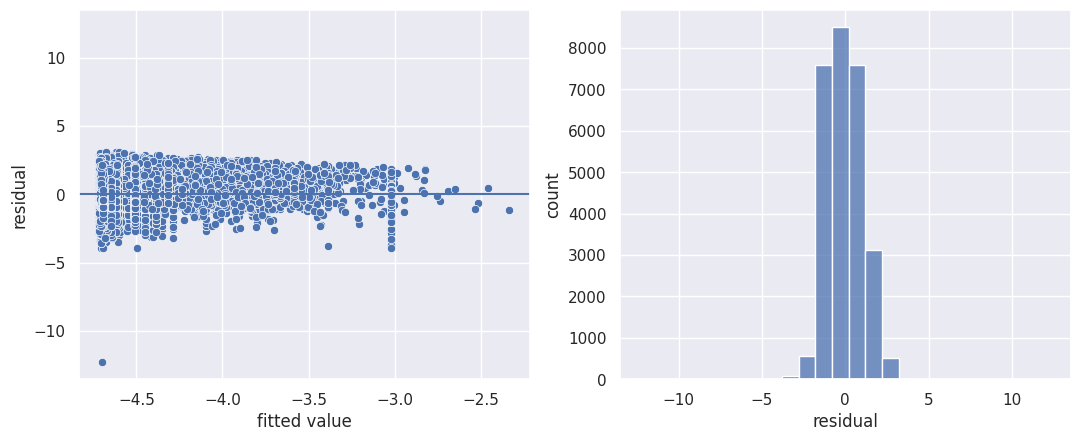

In [82]:
result.plot_residuals()

## Saving the graph

In [83]:
import netpixi

In [84]:
gt_save(g, '../networks/colabs_except_js_python.net.gz')